In [44]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from IPython.display import Audio
import pandas as pd

from fsvc_watermarking import fsvc_watermark_embedding, fsvc_watermark_detection
from patchwork_watermarking import patchwork_watermark_embedding, patchwork_watermark_detection
from norm_space_watermarking import norm_space_watermark_embedding, norm_space_watermark_detection
from dct_watermarking import get_watermark_length, dctb1_watermark_embedding, dctb1_watermark_detection
import warnings
warnings.filterwarnings("ignore")

# Audio Watermarking

Autores:
- Pablo Smolkin
- Francisco Ledesma

La marca de agua de audio es una técnica que permite incrustar información no audible, o apenas audible, en una señal de audio, de manera que no se pueda eliminar sin degradar la señal de audio original

## Metricas

### Bit Error Rate

\begin{equation*}
BER = \frac{1}{N} \sum_{i=1}^{N} w_i \oplus \hat{w}_i
\end{equation*}

* N es el número total de bits en la marca de agua.
* $w_i$ es el i-ésimo bit de la secuencia original.
* $\hat{w}_i$ es el i-ésimo bit de la secuencia detectada.
* La función a $\oplus$ b devolvera un arreglo con tantos 1's como bits distintos haya.


### Signal to Noise Ratio

\begin{equation*}
SNR = 10 \log_{10}\left(\frac{\sum_{i=1}^{N} s_i^2}{\sum_{i=1}^{N} (s_i - \hat{s}_i)^2}\right)
\end{equation*}

In [45]:
def calculate_ber(watermark, watermark_detected):
  return np.sum(watermark != watermark_detected)/len(watermark)

# following function calculate the SNR from the original and watermarked signal
def calculate_snr(original_signal, watermarked_signal):
  noise = original_signal - watermarked_signal
  return 10*np.log10(np.sum(original_signal**2)/np.sum(noise**2))

In [46]:
# dictionary to compare the different watermarking methods
watermarking_methods = {
    'patchwork': {
        'SNR [dB]': 0,
        'BER [%]': 0
    },
    'norm_space': {
        'SNR [dB]': 0,
        'BER [%]': 0
    },
    'dct': {
        'SNR [dB]': 0,
        'BER [%]': 0
    }
}

In [47]:
# Import recorded speech signals
fs_hamlet, hamlet_en = wavfile.read('audios/Hamlet.wav')
hamlet_en = np.mean(hamlet_en, axis=1)
t_hamlet = np.arange(0, 4, 1/fs_hamlet)
print('Hamlet.wav: ', hamlet_en.shape, fs_hamlet)
Audio(hamlet_en, rate=fs_hamlet)

Hamlet.wav:  (176400,) 44100


## Watermarking DCT-Based

* En general, las tecnicas de watermarking en audio se basan en modular las componentes de baja frecuencia de las señales de audio.
* Para el analisis espectral se suele utilizar la DFT, DCT y DWT.
* DWT tiene mayor complejidad computacional. La diferencia entre la DFT y la DCT es que la DCT solo usa funciones coseno.
* Como la DCT asume simitria continua en los limites, la DCT tiende a concentrar la energia en los coeficientes de baja frecuencia. Por este motivo el autor habla de "compactacion espectral" y refiere a que por este motivo la DCT es adecuada para aplicaciones de compresion.

### Introduccion:
La tecnica se aplica ventana a ventana de longitud 'lf'.

Cada ventana tiene dos secciones: 
* 'lt': una sección pequeña de muestras para suavizar la transición entre ventanas.
* 'lw': una sección grande de muestras convertidas en coeficientes DCT para colocar la marca de agua.

El autor del paper sugiere utilizar, para una señal muestreada a 44.1 kHz lt = 64 y lw = 4096.
La señal muestreada a 44.1 kHz resulta en una resolución temporal de 94.3 ms y una resolución de frecuencia de 5.38 Hz con una DCT de 4096 puntos.
Se utiliza una ventana más grande para obtener una alta resolución espectral.

El enfoque principal es cómo manipular los coeficientes DCT en cada ventana.

Se aprovecha las propiedades de enmascaramiento auditivo para ocultar la marca de agua en un sonido de mayor intensidad dentro de cada banda crítica. Se asume que el umbral de enmascaramiento auditivo estimado se mantiene aproximadamente a un nivel fijo en cada banda, y cada banda contiene suficientes coeficientes DCT para acomodar la variación de energía debido a la marca de agua. Como las señales de audio concentran su energia en frecuencia por debajo de 1kHz el proceso se enfoca en los primeros 168 coeficientes DCT, que se dividen en tres bandas de frecuencia, cada una cubriendo un rango de 301.46 Hz para la frecuencia de muestreo dada.

### Enmascaramiento auditivo

Según la teoría del enmascaramiento auditivo, una marca de agua insertada será inaudible si la distorsión de energía se encuentra por debajo del umbral de enmascaramiento.
Se toma la mitad de una banda de frecuencia como la frecuencia representativa $f_{rep}$ y se convierte a una escala Bark.
\begin{equation*}
z_{\text{rep}} = 13 \tan^{-1}(0.00076f_{\text{rep}}) + 3.5 \tan^{-1}\left(\left(\frac{f_{\text{rep}}}{7500}\right)^2\right)
\end{equation*}

Luego, el umbral de enmascaramiento auditivo para una banda con una frecuencia central Bark $z_{\text{rep}}$ es:
\begin{equation*}
a(z_{\text{rep}}) = \lambda a_{\text{tmn}}(z_{\text{rep}}) + (1-\lambda)a_{\text{n\text{mn}}}(z_{\text{rep}})
\end{equation*}
Donde λ es el factor de tonalidad que varía entre 0 y 1. $a_{\text{tmn}}(z)$ es el índice de enmascaramiento tono-ruido, que se estima como $a_{\text{tmn}}(z) = 0.275z + 15.025$, y $a_{\text{n\text{mn}}}(z)$ es el índice de enmascaramiento ruido-ruido, que se fija generalmente en $a_{\text{n\text{mn}}}(z) = -9$.

$a_{\text{tmn}}(z_{\text{rep}})$ puede considerarse como el nivel máximo permisible de variación de energía sin causar una distorsión notable, especialmente en frecuencias cercanas a $z_{\text{rep}}$.


Por lo tanto, la marca de agua incrustada se volverá imperceptible si la variación de energía no supera $E_{\text{mask}}$
\begin{equation*}
E_{\text{mask}} = 10^{a_{\text{tmn}}(z_{\text{rep}})/10}E_c \text{    ;\;\;    con   } E_c = \sum_{i=1}^{56}c_i^2
\end{equation*}

### QIM

Los 56 coeficientes en una banda de frecuencia se dividen en dos grupos: G1 y G2. 
Cada grupo contiene índices de coeficientes DCT, con G1 teniendo los índices de LG1 coeficientes y G2 teniendo los índices de LG2 coeficientes.

Los coeficientes DCT en el grupo G1 seran utilizados para colocar la marca de agua. Por otro lado, los coeficientes en el grupo G2 están destinados a absorber la variación de energía que resulta de colocar la marca de agua. La idea de esto es mantener un nivel de energía constante que permitirá recuperar los pasos de cuantificación de la señal con la marca de agua.

Aumentar la proporción de LG1 a LG2 aumentará la capacidad del payload. Sin embargo, hay un límite en la cantidad de absorción de energía que cada coeficiente puede manejar. 

El autor del paper, de manera experimental, eligió los tamaños de LG1 y LG2 como 48 y 8, respectivamente.

Los indices que corresponden a G1 y a G2 se eligen de manera aleatoria. Se podria implementar una semilla para generar la secuencia aleatoria y que se utilize como una clave secreta.

Para introducir cada bit $w_b$ de la marca de agua en cada coeficiente de G1 se sigue la regla QIM que dice:

\begin{equation*}
\hat{c_k} = 
\begin{cases} 
\left\lfloor \frac{c_k}{\Delta} + 0.5 \right\rfloor\Delta, & \text{si } w_b = 0 \\
\left\lfloor \frac{c_k}{\Delta} \right\rfloor \Delta + \frac{\Delta}{2}, & \text{si } w_b = 1 
\end{cases}
\end{equation*}

donde $\hat{c_k}$ es la version cuantizada de $c_k$. $\Delta$ se calcula como:
\begin{equation*}
\Delta = \sqrt{E_{\text{mask}}}
\end{equation*}


  De esta manera, en cada frame tenemos LG1 bits del mensaje en esta banda de frecuencia.

### Transiciones suaves entre ventanas

La modulacion de los coeficientes DCT pueden producir discontinuidades abruptas en los extremos de cada ventana. Esto puede producir que se escuchen clicks en el audio con marca de agua. Para solucionar esto, luego de aplicar la inversa de la DCT se aplica una interpolacion lineal en los extremos de las ventanas para eliminar las transiciones abruptas.

### Extraccion de la marca de agua

Luego, para extraer la marca de agua, conociendo el indice de los coeficientes modulados, se aplica la siguiente regla de decisión

\begin{equation*}
\tilde{w}_b = 
\begin{cases} 
1, & \text{si } \left| \frac{c_k}{\Delta} - \left\lfloor \frac{c_k}{\Delta} \right\rfloor - 0.5 \right| < 0.25 \\
0, & \text{si } caso contrario
\end{cases}
\end{equation*}



In [48]:
# Create a sine wave signal as test signal and an alternating bit sequence as watermark
fs = 44100
t = np.arange(0, 2, 1/fs)
test_signal = np.sin(2*np.pi*440*t)

In [94]:
# Parameters
lt = 64
lw = 4096
lG1 = 48
lG2 = 8
band_size = lG1+lG2

# Create watermark
watermark_lenght_dct = get_watermark_length(signal=test_signal, lt=lt, lw=lw, lG1=lG1)
print(watermark_lenght_dct)
watermark_dct = np.tile(np.array([1, 0]), watermark_lenght_dct//2)
# Embed watermark
watermarked_signal_dct, G1_inds = dctb1_watermark_embedding(signal=test_signal, watermark=watermark_dct, sr=fs, lt=lt, lw=lw, band_size=band_size, lG1=lG1, lG2=lG2)
#print(G1_inds)
# Detect watermark
detected_watermark_dct = dctb1_watermark_detection(watermarked_signal=watermarked_signal_dct, sr=fs, G1_inds=G1_inds, lt=lt, lw=lw, band_size=band_size)

print(f"BER = {calculate_ber(watermark_dct, detected_watermark_dct)*100:.2f}%")

1008
(1008,)
BER = 0.20%


In [50]:
# Play original signal
Audio(data=test_signal, rate=fs)

In [51]:
# Play watermarked signal
Audio(data=watermarked_signal_dct, rate=fs)

In [52]:
# Plot original and watermarked signal
plt.figure(figsize=(10, 5))
plt.plot(t, test_signal, label="Original signal", color=(0, 0, 1.0, 1.0))
plt.plot(t, watermarked_signal_dct, label="Watermarked signal", color=(1.0, 0, 0, 1.0))
plt.xlim(0, 0.025)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

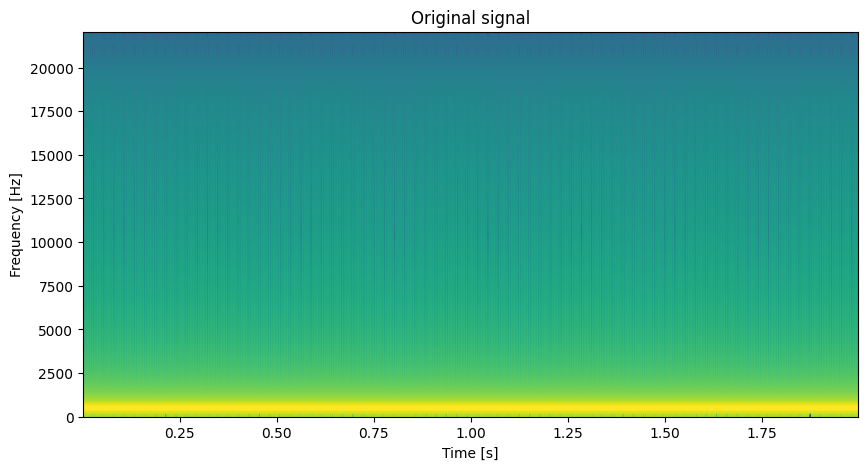

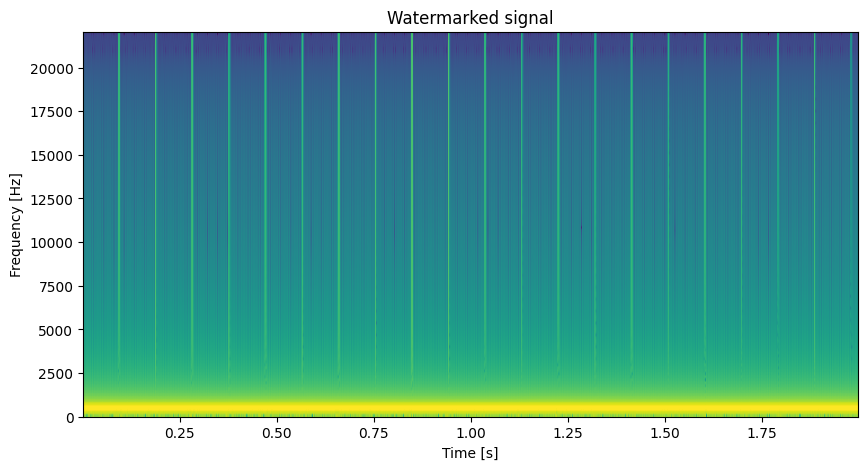

In [53]:
# Plot spectrogram of original and watermarked signal
plt.figure(figsize=(10, 5))
plt.specgram(test_signal, Fs=fs)
plt.title("Original signal")
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.show()

plt.figure(figsize=(10, 5))
plt.specgram(watermarked_signal_dct, Fs=fs)
plt.title("Watermarked signal")
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.show()

hamlet -> convertir a 44100

In [54]:
# Parameters
lt = 64
lw = 4096
lG1 = 48
lG2 = 8
band_size = lG1+lG2

# Create watermark
watermark_lenght_dct = get_watermark_length(signal=hamlet_en, lt=lt, lw=lw, lG1=lG1)
watermark_dct = np.tile(np.array([1, 0]), watermark_lenght_dct//2)

# Embed watermark
watermarked_signal_dct, G1_inds = dctb1_watermark_embedding(signal=hamlet_en, watermark=watermark_dct, sr=fs, lt=lt, lw=lw, band_size=band_size, lG1=lG1, lG2=lG2)

# Detect watermark
detected_watermark_dct = dctb1_watermark_detection(watermarked_signal=watermarked_signal_dct, sr=fs_hamlet, G1_inds=G1_inds, lt=lt, lw=lw, band_size=band_size)

print(f"BER = {calculate_ber(watermark_dct, detected_watermark_dct)*100:.2f}%")
watermarking_methods['dct']['BER [%]'] = calculate_ber(watermark_dct, detected_watermark_dct)*100
print(f"SNR = {calculate_snr(hamlet_en, watermarked_signal_dct):.2f} dB")
watermarking_methods['dct']['SNR [dB]'] = calculate_snr(hamlet_en, watermarked_signal_dct)

BER = 0.60%
SNR = 10.10 dB


In [55]:
# Play watermarked signal
Audio(data=watermarked_signal_dct, rate=fs_hamlet)

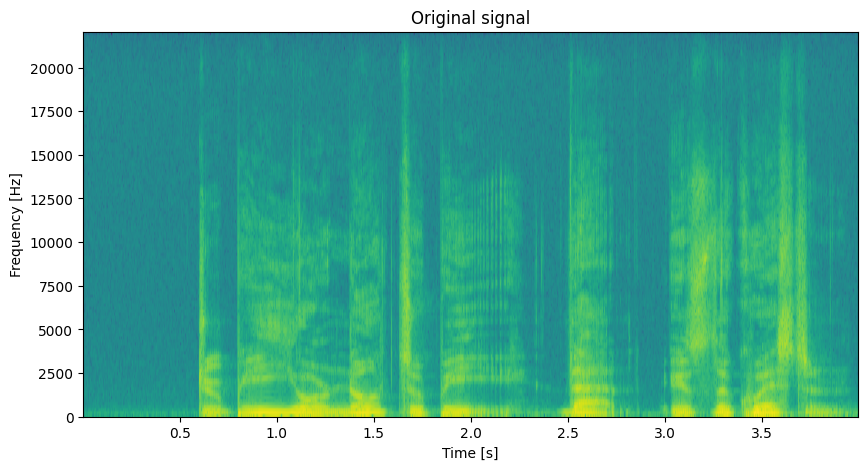

In [56]:
# Plot spectrogram of original and watermarked signal
plt.figure(figsize=(10, 5))
plt.specgram(hamlet_en, Fs=fs_hamlet)
plt.title("Original signal")
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.show()

plt.figure(figsize=(10, 5))
plt.specgram(watermarked_signal_dct, Fs=fs_hamlet)
plt.title("Watermarked signal")
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.show()

### Patchwork

teoria patchwork

In [57]:
# Create a sine wave signal as test signal and an alternating bit sequence as watermark
fs = 16000
t = np.arange(0, 2, 1/fs)
test_signal = np.sin(2*np.pi*500*t)

In [58]:
watermark_patch = np.tile(np.array([1, 0]), 1024)

watermarked_signal_patch = patchwork_watermark_embedding(signal=test_signal, watermark=watermark_patch, sr=fs)

detected_watermark_patch = patchwork_watermark_detection(watermarked_signal=watermarked_signal_patch, watermark_length=len(watermark_patch), sr=fs)

print(f"BER = {calculate_ber(watermark_patch, detected_watermark_patch)*100:.2f}%")

BER = 0.00%


In [59]:
# Play original signal
Audio(data=test_signal, rate=fs)

In [60]:
# Play watermarked signal
Audio(data=watermarked_signal_patch, rate=fs)

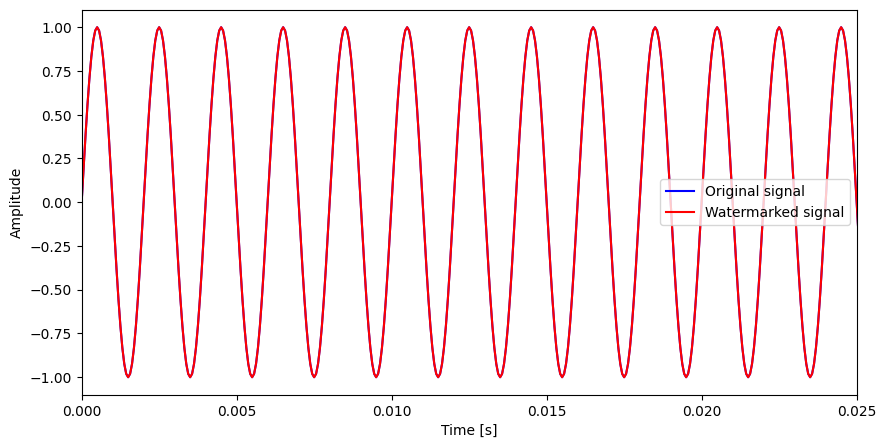

In [61]:
# Plot original and watermarked signal
plt.figure(figsize=(10, 5))
plt.plot(t, test_signal, label="Original signal", color=(0, 0, 1.0, 1.0))
plt.plot(t, watermarked_signal_patch, label="Watermarked signal", color=(1.0, 0, 0, 1.0))
plt.xlim(0, 0.025)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

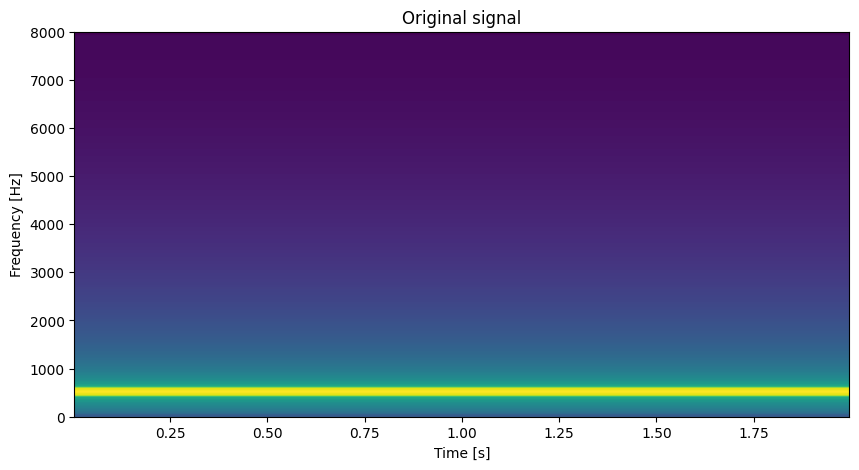

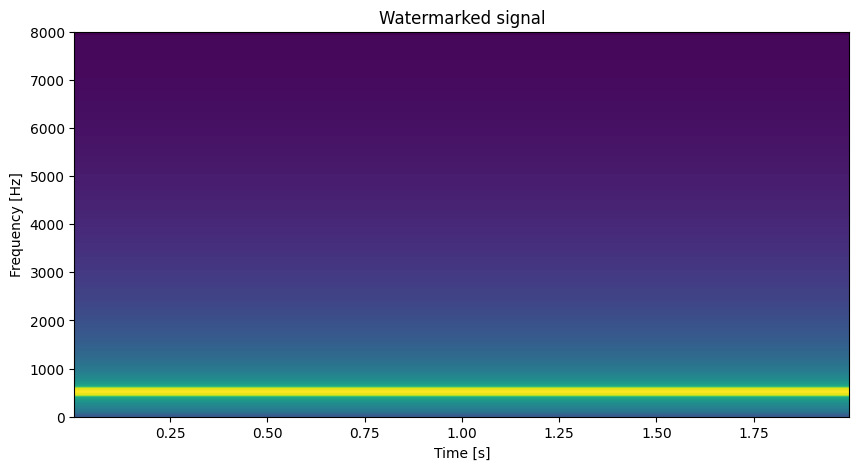

In [62]:
# Plot spectrogram of original and watermarked signal
plt.figure(figsize=(10, 5))
plt.specgram(test_signal, Fs=fs)
plt.title("Original signal")
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.show()

plt.figure(figsize=(10, 5))
plt.specgram(watermarked_signal_patch, Fs=fs)
plt.title("Watermarked signal")
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.show()

In [63]:
watermark_patch = np.tile(np.array([1, 0]), 2**10)

watermarked_signal_patch = patchwork_watermark_embedding(signal=hamlet_en, watermark=watermark_patch, sr=fs_hamlet)

detected_watermark_patch = patchwork_watermark_detection(watermarked_signal=watermarked_signal_patch, watermark_length=len(watermark_patch), sr=fs_hamlet)

print(f"BER = {calculate_ber(watermark_patch, detected_watermark_patch)*100:.2f}%")
watermarking_methods['patchwork']['BER [%]'] = calculate_ber(watermark_patch, detected_watermark_patch)*100
print(f"SNR = {calculate_snr(hamlet_en, watermarked_signal_patch):.2f} dB")
watermarking_methods['patchwork']['SNR [dB]'] = calculate_snr(hamlet_en, watermarked_signal_patch)

BER = 20.85%
SNR = 34.50 dB


In [64]:
Audio(hamlet_en, rate=fs_hamlet)

In [65]:
Audio(watermarked_signal_patch, rate=fs_hamlet)

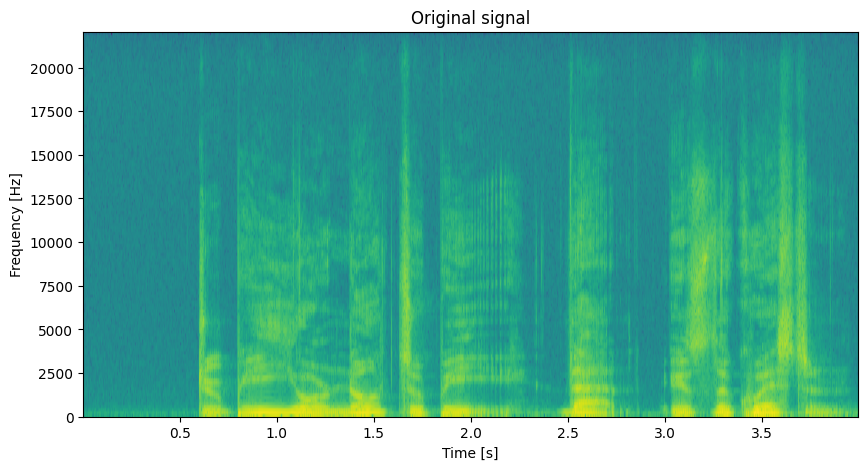

In [66]:
# Plot spectrogram of original and watermarked signal
plt.figure(figsize=(10, 5))
plt.specgram(hamlet_en, Fs=fs_hamlet)
plt.title("Original signal")
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.show()

plt.figure(figsize=(10, 5))
plt.specgram(watermarked_signal_patch, Fs=fs_hamlet)
plt.title("Watermarked signal")
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.show()

### Norm Space

teoria normspace

In [67]:
watermark_ns = np.tile(np.array([1, 0]), len(test_signal)//8)

watermarked_signal_ns = norm_space_watermark_embedding(signal=test_signal, watermark=watermark_ns, delta=0.01)

detected_watermark_ns = norm_space_watermark_detection(watermarked_signal=watermarked_signal_ns, watermark_length=len(watermark_ns), delta=0.01)

print(f"BER = {calculate_ber(watermark_ns, detected_watermark_ns)*100:.2f}%")

BER = 0.00%


In [68]:
# Play original signal
Audio(data=test_signal, rate=fs)

In [69]:
# Play watermarked signal
Audio(data=watermarked_signal_ns, rate=fs)

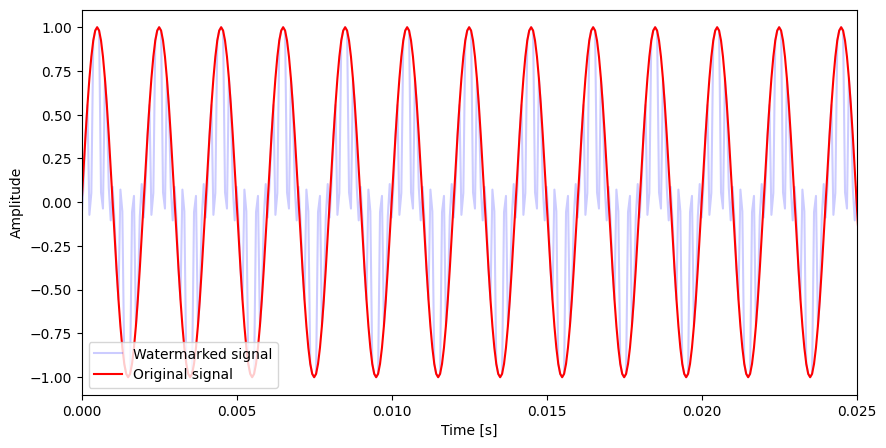

In [70]:
# Plot original and watermarked signal
plt.figure(figsize=(10, 5))
plt.plot(t, watermarked_signal_ns, label="Watermarked signal", color=(0.0, 0, 1.0, 0.2))
plt.plot(t, test_signal, label="Original signal", color=(1.0, 0, 0, 1.0))
plt.xlim(0, 0.025)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

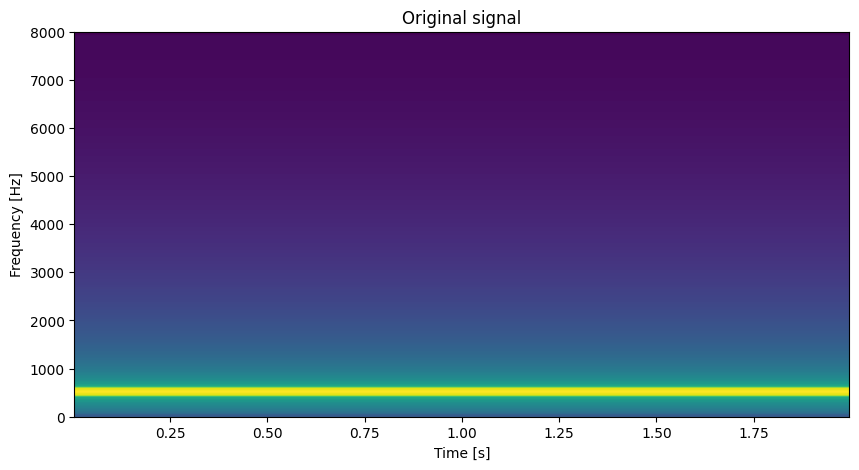

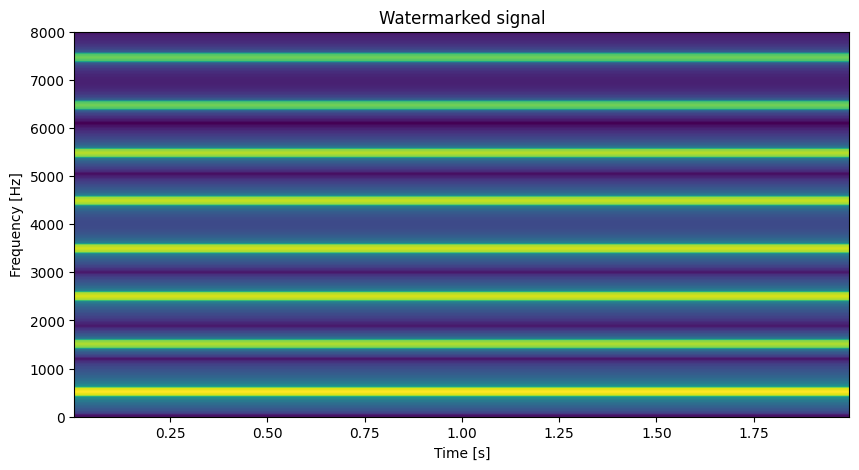

In [71]:
# Plot spectrogram of original and watermarked signal
plt.figure(figsize=(10, 5))
plt.specgram(test_signal, Fs=fs)
plt.title("Original signal")
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.show()

plt.figure(figsize=(10, 5))
plt.specgram(watermarked_signal_ns, Fs=fs)
plt.title("Watermarked signal")
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.show()

In [72]:
watermark_ns = np.tile(np.array([1, 0]), len(hamlet_en)//16)

watermarked_signal_ns = norm_space_watermark_embedding(signal=hamlet_en, watermark=watermark_ns, delta=0.01)

detected_watermark_ns = norm_space_watermark_detection(watermarked_signal=watermarked_signal_ns, watermark_length=len(watermark_ns), delta=0.01)

print(f"BER = {calculate_ber(watermark_ns, detected_watermark_ns)*100:.2f}%")
watermarking_methods['norm_space']['BER [%]'] = calculate_ber(watermark_ns, detected_watermark_ns)*100

watermarked_signal_ns[np.isnan(watermarked_signal_ns)] =  0

print(f"SNR = {calculate_snr(hamlet_en, watermarked_signal_ns):.2f} dB")
watermarking_methods['norm_space']['SNR [dB]'] = calculate_snr(hamlet_en, watermarked_signal_ns)


BER = 0.20%
SNR = 3.58 dB


In [73]:
# Play watermarked signal
Audio(data=watermarked_signal_ns, rate=fs_hamlet)

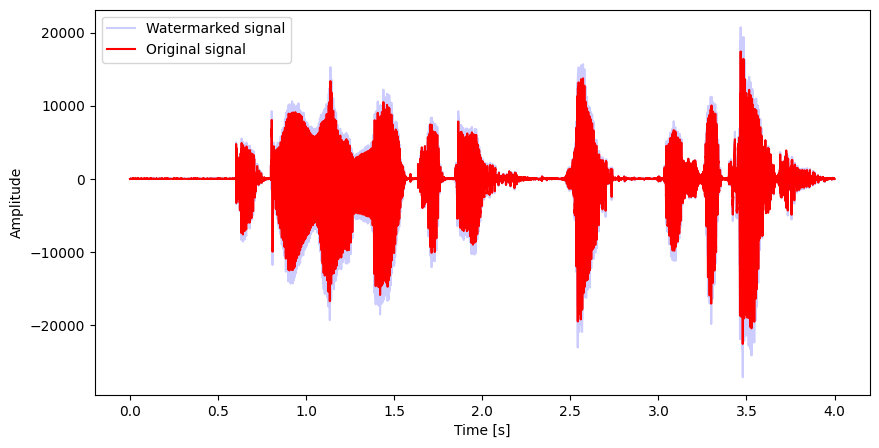

In [74]:
# Plot original and watermarked signal
plt.figure(figsize=(10, 5))
plt.plot(t_hamlet, watermarked_signal_ns, label="Watermarked signal", color=(0.0, 0, 1.0, 0.2))
plt.plot(t_hamlet, hamlet_en, label="Original signal", color=(1.0, 0, 0, 1.0))
# plt.xlim(0, 0.025)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

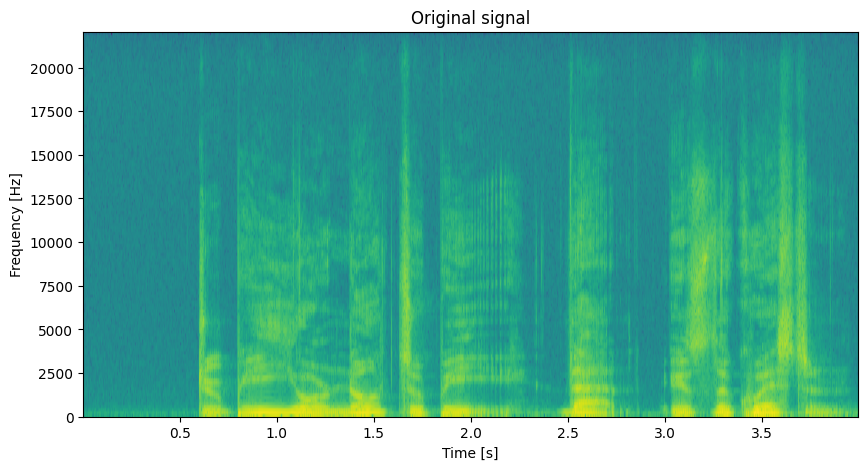

In [75]:
# Plot spectrogram of original and watermarked signal
plt.figure(figsize=(10, 5))
plt.specgram(hamlet_en, Fs=fs_hamlet)
plt.title("Original signal")
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.show()

plt.figure(figsize=(10, 5))
plt.specgram(watermarked_signal_ns, Fs=fs_hamlet)
plt.title("Watermarked signal")
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.show()

In [76]:
watermarking_methods_df = pd.DataFrame.from_dict(watermarking_methods, orient='index')
watermarking_methods_df = watermarking_methods_df.round(2)
display(watermarking_methods_df)

SNR [dB]  BER [%]
patchwork      34.50    20.85
norm_space      3.58     0.20
dct            10.10     0.60

### FSVC

In [77]:
# Create a sine wave signal as test signal and an alternating bit sequence as watermark
fs = 44100
t = np.arange(0, 2, 1/fs)
test_signal = np.sin(2*np.pi*441*t)

In [78]:
watermark_fsvc = np.tile(np.array([1, 0]), 1024)

watermarked_signal_fsvc = fsvc_watermark_embedding(test_signal, watermark_fsvc, sr=fs)

detected_watermark_fsvc = fsvc_watermark_detection(watermarked_signal_fsvc, sr=fs)

print(f"BER = {calculate_ber(watermark_fsvc, detected_watermark_fsvc)*100:.2f}%")
print(f"SNR = {calculate_snr(test_signal, watermarked_signal_fsvc):.2f} dB")

BER = 0.05%
SNR = 42.00 dB


In [79]:
# Play original signal
Audio(data=test_signal, rate=fs)

In [80]:
# Play watermarked signal
Audio(data=watermarked_signal_fsvc, rate=fs)

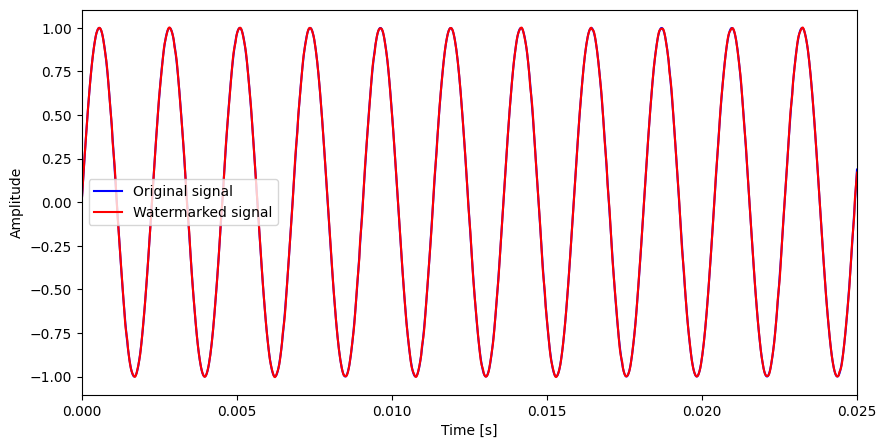

In [81]:
# Plot original and watermarked signal
plt.figure(figsize=(10, 5))
plt.plot(t, test_signal, label="Original signal", color=(0, 0, 1.0, 1.0))
plt.plot(t, watermarked_signal_fsvc, label="Watermarked signal", color=(1.0, 0, 0, 1.0))
plt.xlim(0, 0.025)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

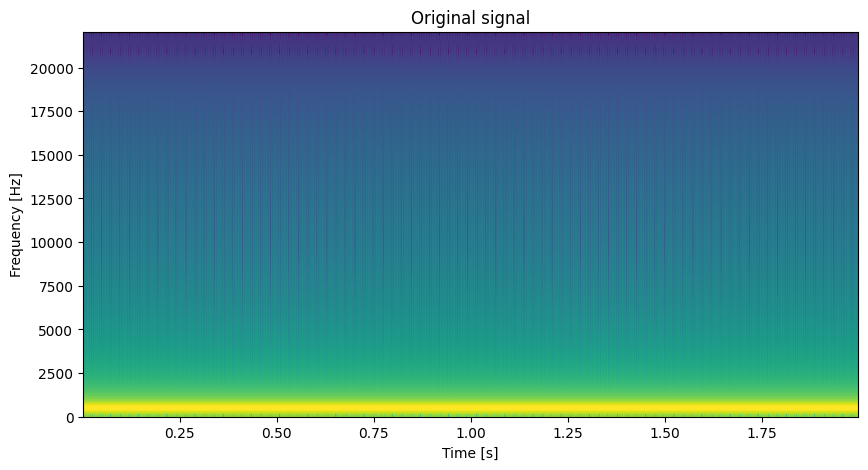

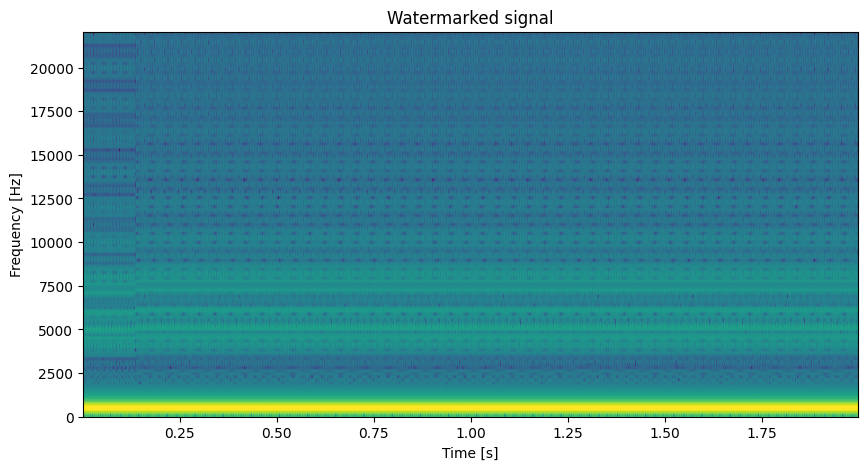

In [82]:
# Plot spectrogram of original and watermarked signal
plt.figure(figsize=(10, 5))
plt.specgram(test_signal, Fs=fs)
plt.title("Original signal")
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.show()

plt.figure(figsize=(10, 5))
plt.specgram(watermarked_signal_fsvc, Fs=fs)
plt.title("Watermarked signal")
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.show()

In [83]:
watermark_fsvc = np.tile(np.array([1, 0]), 4096)

watermarked_signal_fsvc = fsvc_watermark_embedding(hamlet_en, watermark_fsvc, sr=fs_hamlet)

detected_watermark_fsvc = fsvc_watermark_detection(watermarked_signal_fsvc, sr=fs_hamlet)

print(f"BER = {calculate_ber(watermark_fsvc, detected_watermark_fsvc)*100:.2f}%")
# watermarking_methods['fsvc']['BER [%]'] = calculate_ber(watermark_fsvc, detected_watermark_fsvc)*100
print(f"SNR = {calculate_snr(hamlet_en, watermarked_signal_fsvc):.2f} dB")
# watermarking_methods['fsvc']['SNR [dB]'] = calculate_snr(hamlet_en, watermarked_signal_fsvc)

BER = 0.01%
SNR = 28.16 dB


In [84]:
# Play watermarked signal
Audio(data=watermarked_signal_fsvc, rate=fs_hamlet)

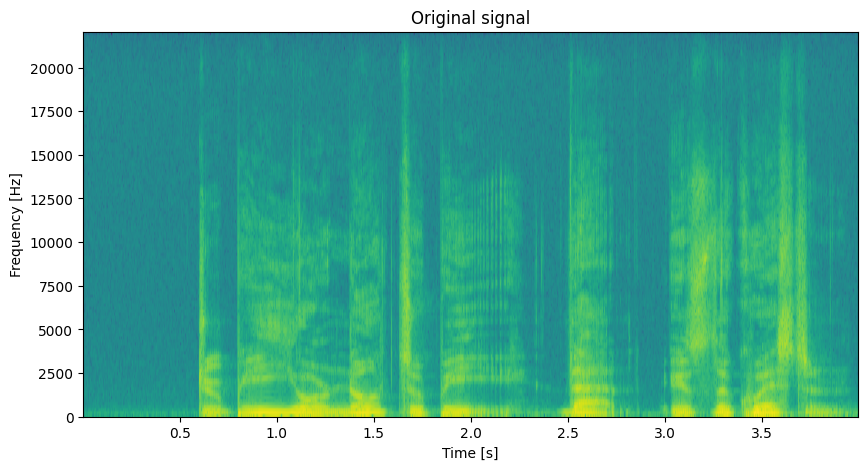

In [85]:
# Plot spectrogram of original and watermarked signal
plt.figure(figsize=(10, 5))
plt.specgram(hamlet_en, Fs=fs_hamlet)
plt.title("Original signal")
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.show()

plt.figure(figsize=(10, 5))
plt.specgram(watermarked_signal_fsvc, Fs=fs_hamlet)
plt.title("Watermarked signal")
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.show()